# Imports & Downloads

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fried\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fried\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fried\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fried\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
stop_words = stopwords.words()

# Loading the data

In [7]:
col_names = ['thread', 'topic', "sentiment", "tweet"]
# df_raw = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\twitter_validation.csv",
#                      names=col_names, index_col=0)
df_raw = pd.read_csv("C:\\Users\\fried\\Desktop\\WS 24_25\\Projektpraktikum\\WebScience24\\data\\twitter_hate-speech\\twitter_validation.csv",
                    names=col_names, index_col=0)

In [8]:
col_names = ['thread', 'topic', "sentiment", "tweet"]
# df_raw = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\twitter_training.csv",
#                      names=col_names, index_col=0, encoding="utf-8")
df_raw = pd.read_csv("C:\\Users\\fried\\Desktop\\WS 24_25\\Projektpraktikum\\WebScience24\\data\\twitter_hate-speech\\twitter_training.csv",
                     names=col_names, index_col=0, encoding="utf-8")
df_raw = df_raw.reset_index()

In [9]:
df_raw.head()

,thread,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
#  avoid characters of text column to be cut off by default Pandas DataFrame limitations
pd.set_option('display.max_colwidth', 400)

## Save val data

In [11]:
train_df = df_raw.sample(frac = 0.8)
train_df.shape

(59746, 4)

In [12]:
val_df = df_raw.drop(train_df.index)
val_df.shape

(14936, 4)

In [13]:
filepath = Path('data/twitter_validation_new.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)

In [14]:
val_df.to_csv(filepath)

# Preparing the data

In [15]:
df = train_df

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59746 entries, 17268 to 14997
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   thread     59746 non-null  int64 
 1   topic      59746 non-null  object
 2   sentiment  59746 non-null  object
 3   tweet      59219 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


## Duplicate-Check

In [17]:
df.duplicated().sum()

1791

=> bei der Menge an Daten (ca. 75k) sollten die Duplikate entfernt werden

In [18]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## Delete Noise // Irrelevant Data

In [36]:
df = df[df['sentiment'] != 'Irrelevant']

## Null-Check

In [38]:
df.isna().sum()

thread        0
topic         0
sentiment     0
tweet         0
char_count    0
word_count    0
dtype: int64

=> es fehlen nur Einträge bei Tweet, dabei handelt es sich aber um das entscheidende Feature; ohne Tweet ist der Eintrag wertlos, daher droppen

In [39]:
df.dropna(axis="rows", inplace=True)
df.isna().sum()

thread        0
topic         0
sentiment     0
tweet         0
char_count    0
word_count    0
dtype: int64

## Inconsistent text & typos

In [40]:
print('Column: Topic')
print(df['topic'].value_counts().sort_index())

Column: Topic
Amazon                               1667
ApexLegends                          1702
AssassinsCreed                       1535
Battlefield                          1073
Borderlands                          1589
CS-GO                                1258
CallOfDuty                           1324
CallOfDutyBlackopsColdWar            1339
Cyberpunk2077                        1376
Dota2                                1456
FIFA                                 1357
Facebook                             1318
Fortnite                             1116
Google                               1370
GrandTheftAuto(GTA)                  1174
Hearthstone                          1599
HomeDepot                            1557
LeagueOfLegends                      1603
MaddenNFL                            1812
Microsoft                            1718
NBA2K                                1727
Nvidia                               1701
Overwatch                            1296
PlayStation5(PS5)   

=> keine Typos erkennbar
=> Doppelung von CallOfDuty / CallOfDutyBlackopsColdWar -> ggf. zusammenlegen

In [41]:
df[(df.topic == "CallOfDuty")]

,thread,topic,sentiment,tweet,char_count,word_count
74,2065,CallOfDuty,Positive,Nice visual two piece here.,27,5
80,2099,CallOfDuty,Negative,@CallofDuty very seriously. We go to fix this issue. please let me know who to contact.,87,16
124,2151,CallOfDuty,Positive,This is not an amateur hour! I am still destroying some Call of Duty: Modern Warfare.. twitch.tv / squatchmd,108,19
171,2329,CallOfDuty,Positive,Good little session report on COD earlier - And absolutely beaming folks,72,12
265,2148,CallOfDuty,Negative,This was amazing.,17,3
...,...,...,...,...,...,...
57505,2209,CallOfDuty,Positive,I'm excited to play Call of Duty.,33,7
57514,2303,CallOfDuty,Positive,Nice!,5,1
57533,2305,CallOfDuty,Neutral,@CallofDuty got a collateral last night at Warzone on a moving vehicle,70,12
57583,2017,CallOfDuty,Positive,thank god... for EOD,20,4


In [42]:
blackops_keywords = "ops|Ops"
df[(df.topic == "CallOfDuty") & (df.tweet.str.contains(blackops_keywords))]

,thread,topic,sentiment,tweet,char_count,word_count
4723,2009,CallOfDuty,Neutral,If anyone anyone knows by me i was literally a god at that Black ops 1 cant wait,80,18
4810,2009,CallOfDuty,Neutral,If anyone knows me i was literally a god at Black ops 1 cant wait,65,15
4891,2188,CallOfDuty,Neutral,"@CallofDuty Can you also change the code H WARZONE to CAMPZONE please???? @Activision So many Dirty Skilled Gamers Camping Buystations, free drops in this game!. I enjoyed Blackout way more....",193,30
7821,2336,CallOfDuty,Neutral,Activision confirms that the title of Call of Duty 2020 Black Ops: Cold War: Do you know your story or are you doomed to repeat it. dlvr.it / Rf3VSg,148,29
8984,2336,CallOfDuty,Neutral,"Activision now confirms further that this 2020'at s new Call of Duty title is Black Ops : Cold War : Know your history, or might be absolutely doomed to repeat it. via dlvr. it / Rf3VSg",185,36
9117,2009,CallOfDuty,Neutral,If anyone knows me i was literally a game before Black ops 1 cant wait,70,15
9138,2188,CallOfDuty,Neutral,"@ CFDuty Can you please change the name of WARZONE to CAMPZONE please??? @ Afvision So many Great Skilled Gamers ""Buystations, Loadout drops in this game!. I enjoyed blackout way more....",187,31
9308,2188,CallOfDuty,Neutral,"@CallofDuty Can you please change the name of WARZONE to CAMPZONE please???? @Activision So many Great Skilled Gamers Camping Buystations, Loadout drops in this game! . I enjoyed Blackout way more....",200,31
11228,2336,CallOfDuty,Neutral,"Activision confirms that 2020's Call of Duty installment is Black Ops: Cold War: Know your history, or be doomed or repeat it. video.it/Rf3VSg",142,23
12322,2216,CallOfDuty,Neutral,"@PlayCODMobile @M2Games2 i love the call of duty, more unfortunately i'm having a lot of audio bug, every time i'm playing the BR mode of the game, the audio just stops, then i have to close it and open dnv the device i'm using is iOS.",235,46


In [43]:
df[(df.topic == "CallOfDutyBlackopsColdWar")]

,thread,topic,sentiment,tweet,char_count,word_count
20,1983,CallOfDutyBlackopsColdWar,Positive,Man I am so hyped for on Thursday,33,8
41,1669,CallOfDutyBlackopsColdWar,Neutral,Credit: @ HNSOfficial _ @ ModernWarzone,39,6
60,1934,CallOfDutyBlackopsColdWar,Negative,Fuck y from ’ all,17,5
105,1770,CallOfDutyBlackopsColdWar,Negative,Black market Cold War zombies is fucking hype!!!!!!,51,8
146,1739,CallOfDutyBlackopsColdWar,Negative,"Watching RhandlerR PC gameplay and all I see is the hackers that are sitting there in their dirty blown out chairs like... ""soon"" pic.twitter.com/GaGtaKpXTh",156,24
...,...,...,...,...,...,...
57362,1666,CallOfDutyBlackopsColdWar,Positive,and LOVING THE CALL OF DUTY: BLACK OPS COLD WAR BETA!!. . MAX RANK FOR TODAY!!!. pic.twitter.com/RDEn8JHSJR,108,17
57390,1659,CallOfDutyBlackopsColdWar,Negative,BO1 is top series of all time,29,7
57511,1773,CallOfDutyBlackopsColdWar,Positive,Good show. @Treyarch may help to play your game.,48,9
57599,1811,CallOfDutyBlackopsColdWar,Positive,I wish Call of Duty Black Ops Cold War was coming out November 3rd instead. Cant wait,85,17


In [44]:
cod_keywords = "verdansk|Verdansk|warzone|Warzone|modern|Modern|warfare|Warfare"
df[(df.topic == "CallOfDutyBlackopsColdWar") & (df.tweet.str.contains(cod_keywords))]

,thread,topic,sentiment,tweet,char_count,word_count
41,1669,CallOfDutyBlackopsColdWar,Neutral,Credit: @ HNSOfficial _ @ ModernWarzone,39,6
230,1778,CallOfDutyBlackopsColdWar,Negative,"I loved Black Ops, but after Modern Warfare this Cold War shit is not for me",76,16
1593,1943,CallOfDutyBlackopsColdWar,Positive,The drinks menu looks so nice. I mean just kinda dont understand why people thought Your CW Worldwide would gets its own BR. They literally said its never going to cross over over to THE Warzone. The big Cold War coming..........,229,41
3848,1875,CallOfDutyBlackopsColdWar,Positive,"A Win for Verdansk's finest.. . ""Mil-sim"". .",46,8
4261,1967,CallOfDutyBlackopsColdWar,Negative,"The latest Warzone and Modern Warfare patch has leaked tons of Black Ops: Cold War details including singleplayer campaign description, editions, and estimated release date. <unk>.",180,26
...,...,...,...,...,...,...
54990,1820,CallOfDutyBlackopsColdWar,Positive,It looks amazing! Have high hopes for this.. given how bad the recent mw / warzone is...,88,17
55721,1943,CallOfDutyBlackopsColdWar,Positive,I just don't understand why people thought the CW would get its own weapons. They literally said it would go to Warzone.,120,22
56344,1875,CallOfDutyBlackopsColdWar,Positive,"After A Quick Win for Verdansk'man s finest... "" Lord Mil - sim ""..",67,14
56479,1778,CallOfDutyBlackopsColdWar,Negative,I used to dig Black Ops but after Modern Warfare The Cold War shit ain’t for me,79,17


In [45]:
print('Column: sentiment')
print(df['sentiment'].value_counts())

Column: sentiment
Negative    17524
Positive    15854
Neutral     14264
Name: sentiment, dtype: int64


=> keine Typos erkennbar

## Outlier

In [46]:
# Spalte: Topic
print(df['topic'].value_counts())

TomClancysGhostRecon                 1865
MaddenNFL                            1812
TomClancysRainbowSix                 1777
Verizon                              1736
NBA2K                                1727
Microsoft                            1718
ApexLegends                          1702
Nvidia                               1701
Amazon                               1667
WorldOfCraft                         1665
johnson&johnson                      1647
LeagueOfLegends                      1603
Hearthstone                          1599
Borderlands                          1589
HomeDepot                            1557
RedDeadRedemption(RDR)               1549
AssassinsCreed                       1535
PlayStation5(PS5)                    1473
Dota2                                1456
Cyberpunk2077                        1376
Google                               1370
FIFA                                 1357
CallOfDutyBlackopsColdWar            1339
CallOfDuty                        

In [47]:
# Spalte: Tweet
# Ansatz: prüfen, ob es Ausreißer bei der Länge und/oder bei der Wortzahl pro Tweets gibt
df["char_count"] = df["tweet"].str.len()
df["word_count"] = df["tweet"].str.split().str.len()
df = df.reset_index(drop=True)

In [48]:
df["char_count"].describe()

count    47642.000000
mean       109.698690
std         79.251224
min          1.000000
25%         48.000000
50%         92.000000
75%        154.000000
max        957.000000
Name: char_count, dtype: float64

Text(0, 0.5, 'Number of Tweets')

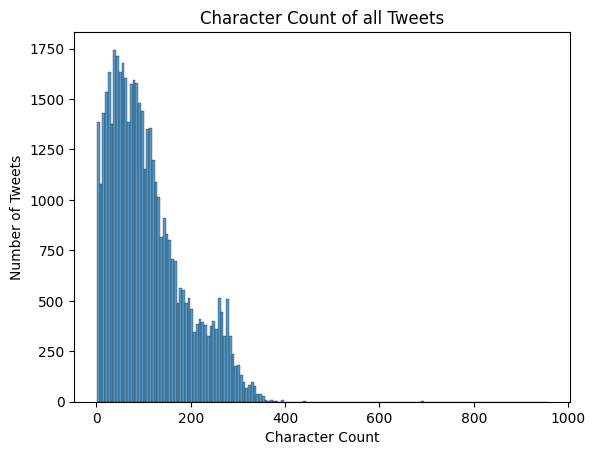

In [49]:
sns.histplot(df["char_count"])

plt.title('Character Count of all Tweets')

plt.xlabel('Character Count')
plt.ylabel('Number of Tweets')

Text(0, 0.5, 'Character Count')

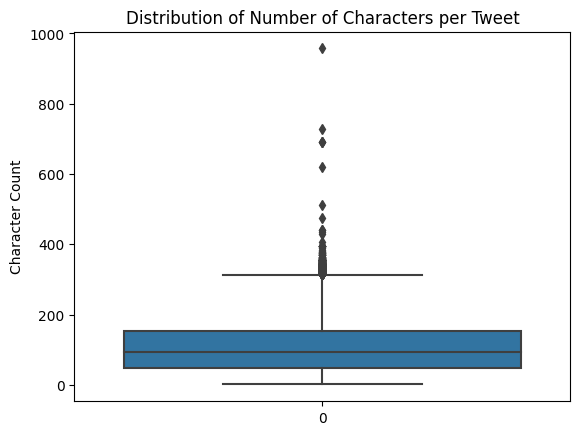

In [52]:
sns.boxplot(df["char_count"])

plt.title('Distribution of Number of Characters per Tweet')

plt.ylabel('Character Count')

In [53]:
df["word_count"].describe()

count    47642.000000
mean        19.387095
std         14.434214
min          0.000000
25%          8.000000
50%         16.000000
75%         27.000000
max        198.000000
Name: word_count, dtype: float64

Text(0, 0.5, 'Number of Tweets')

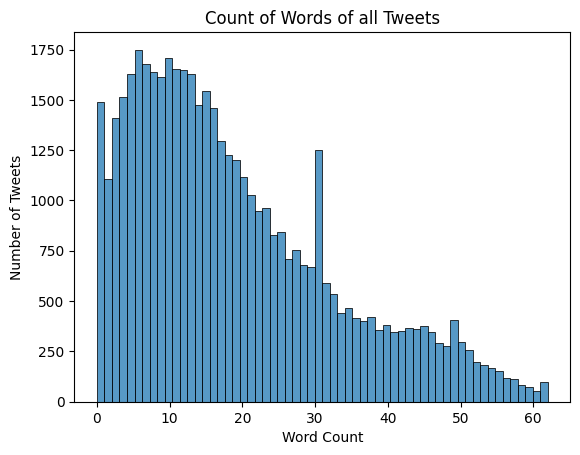

In [70]:
sns.histplot(df["word_count"])

plt.title('Count of Words of all Tweets')

plt.xlabel('Word Count')
plt.ylabel('Number of Tweets')

Text(0, 0.5, 'Number of Words')

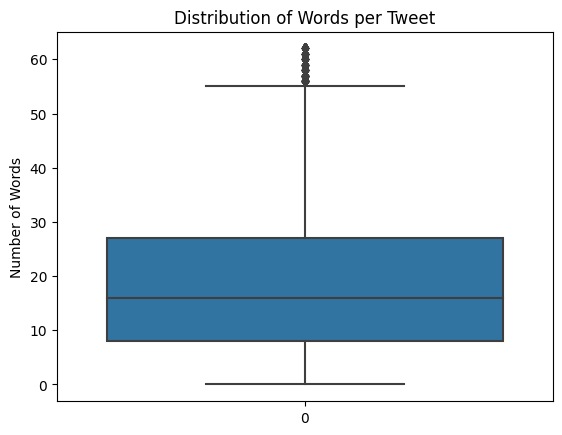

In [71]:
sns.boxplot(data=df["word_count"])

plt.title('Distribution of Words per Tweet')

plt.ylabel('Number of Words')

In [72]:
# Ausreißer auf numerische Art bestimmen: 3 Standardabweichungen vom Mittelwert entfernt = Ausreißer
def find_outlier(data):
    for num_col in data.select_dtypes(["number"]).columns:
        sd = data[num_col].std()
        mean = data[num_col].mean()
        result = [out for out in data[num_col] if (out > mean + 3 * sd) or (out < mean - 3 * sd)]
        print()
        print("Column: ", num_col)
        print("Mean: ", mean, "; Std: ", sd)
        print("Outlier: ", len(result), "; Values: ", sorted(result))

In [73]:
find_outlier(df[["char_count", "word_count"]])


Column:  char_count
Mean:  108.2966176843172 ; Std:  77.17276009735643
Outlier:  28 ; Values:  [340, 340, 341, 341, 341, 341, 341, 341, 342, 342, 342, 343, 343, 343, 343, 344, 345, 345, 345, 345, 345, 346, 346, 346, 347, 347, 348, 348]

Column:  word_count
Mean:  19.101997297525546 ; Std:  13.866400290187038
Outlier:  99 ; Values:  [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62]


In [74]:
df[df["char_count"] >= 349]

,thread,topic,sentiment,tweet,char_count,word_count,sentiment_binary


In [75]:
df[df["word_count"] >= 63]

,thread,topic,sentiment,tweet,char_count,word_count,sentiment_binary


=> Strategie: Einträge droppen, um ML Modelle nicht durch Ausreißer zu beeinflussen (bei DeepLearning-Modellen tendenziell irrelevant)

In [59]:
df = df[df["char_count"] < 349]
df[df["char_count"] >= 349]

,thread,topic,sentiment,tweet,char_count,word_count


In [76]:
df = df[df["word_count"] < 63]
df[df["word_count"] >= 63]

,thread,topic,sentiment,tweet,char_count,word_count,sentiment_binary


In [36]:
# df.drop(['Char_Count', 'Word_Count'], axis=1, inplace=True)

## Datensatz nach Bereinigung

In [77]:
print(df.count())
print(df_raw.count())
print(df.count() - df_raw.count())
print(df.count() / df_raw.count() - 1)

thread              47364
topic               47364
sentiment           47364
tweet               47364
char_count          47364
word_count          47364
sentiment_binary    47364
dtype: int64
thread       74682
topic        74682
sentiment    74682
tweet        73996
dtype: int64
char_count              NaN
sentiment          -27318.0
sentiment_binary        NaN
thread             -27318.0
topic              -27318.0
tweet              -26632.0
word_count              NaN
dtype: float64
char_count               NaN
sentiment          -0.365791
sentiment_binary         NaN
thread             -0.365791
topic              -0.365791
tweet              -0.359911
word_count               NaN
dtype: float64


## Check Val/Test-Data

In [38]:
# df_val_raw = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\twitter_validation.csv", index_col=0) # Fehlerhaft

=> Bewertung Validation-Daten: sehr viele Fehler, ohne händisches Säubern ggf. nicht verwendbar, von der Menge her gering (> 2000)



## Save cleaned Data

In [78]:
filepath = Path('data/twitter_training_cleaned.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)

In [79]:
df.to_csv(filepath)

# EDA

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47364 entries, 0 to 47641
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   thread            47364 non-null  int64 
 1   topic             47364 non-null  object
 2   sentiment         47364 non-null  object
 3   tweet             47364 non-null  object
 4   char_count        47364 non-null  int64 
 5   word_count        47364 non-null  int64 
 6   sentiment_binary  47364 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 2.6+ MB


In [81]:
df.describe()

,thread,char_count,word_count
count,47364.000000,47364.000000,47364.000000
mean,6555.532683,108.296618,19.101997
std,3759.577942,77.172760,13.866400
min,1.000000,1.000000,0.000000
25%,3286.000000,47.000000,8.000000
50%,6803.000000,91.000000,16.000000
75%,9717.000000,152.000000,27.000000
max,13198.000000,348.000000,62.000000


## Korrelationsanalyse

In [82]:
df["sentiment_binary"] = df["sentiment"] == "Negative"

In [88]:
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

TypeError: corr() got an unexpected keyword argument 'numeric_only'

In [89]:
target_corr = df.corr(numeric_only=True)["sentiment_binary"]
target_corr.abs().sort_values(ascending=False)

TypeError: corr() got an unexpected keyword argument 'numeric_only'

Korrelationsanalyse feature<->target => keine originären numerischen Werte, bei den erzeugten numerischen Werten keine nennenswerte Korrelation erkennbar

## Targetanalyse

In [90]:
df["sentiment"].value_counts()

Negative    17419
Positive    15783
Neutral     14162
Name: sentiment, dtype: int64

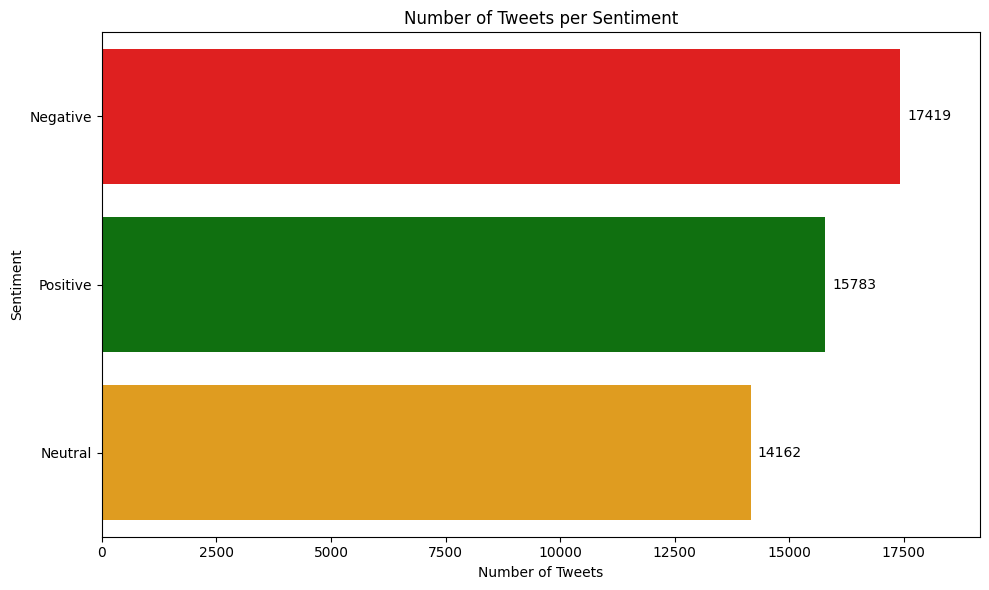

In [94]:
color_mapping = {
    'Negative': 'red',
    'Positive': 'green',
    'Neutral': 'orange',
    #'Irrelevant': 'grey'
}

counts = df['sentiment'].value_counts().reset_index()
counts.columns = ['sentiment', 'count']

counts['color'] = counts['sentiment'].map(color_mapping)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=counts, y='sentiment', x='count', palette=counts['color'])

for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

ax.set_xlim(0, counts['count'].max() * 1.1)

ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Sentiment')


plt.title('Number of Tweets per Sentiment')

plt.tight_layout()
plt.show()

## Featureanalyse

Text(0.5, 1.0, 'Number of Tweets per Topic')

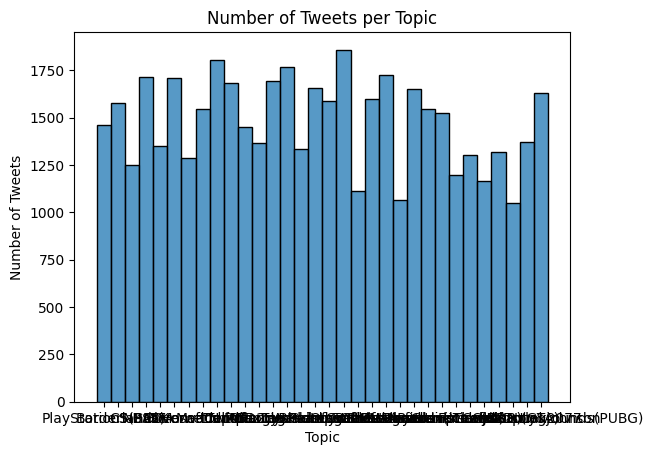

In [101]:
# Feature: Topic
sns.histplot(
    df["topic"])  # Topics sind (grob) gleichverteilt, ggf. ein Ausreißer falls beide COD-Topics zusammengelegt werden

plt.ylabel('Number of Tweets')
plt.xlabel('Topic')

plt.title('Number of Tweets per Topic')

<AxesSubplot:xlabel='word_count', ylabel='Count'>

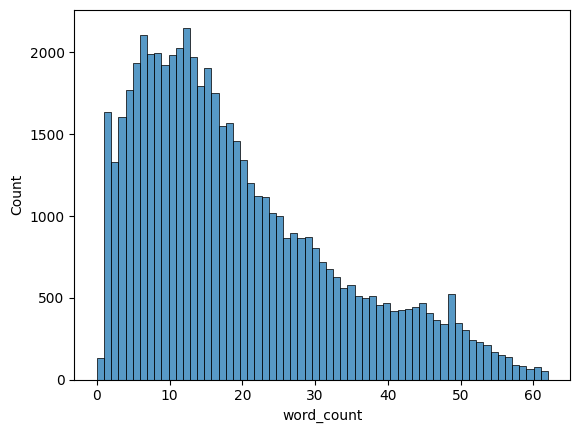

In [62]:
# Feature: Tweet
sns.histplot(df["word_count"])

# redudant to one of the charts above (section1) -- is this intended or shall we get rid off one?

<AxesSubplot:xlabel='char_count', ylabel='Count'>

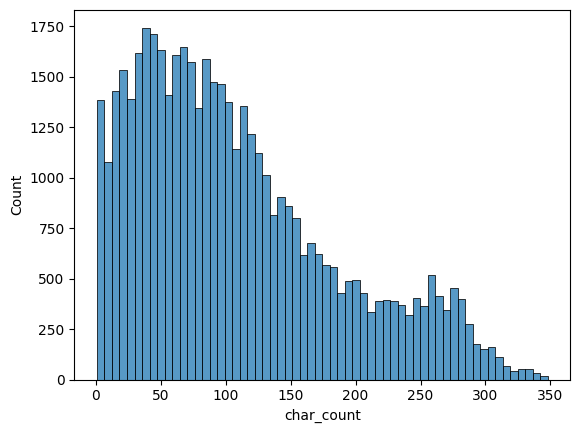

In [103]:
sns.histplot(df["char_count"])

# redudant to one of the charts above (section1) -- is this intended or shall we get rid off one?

## Feature x Target

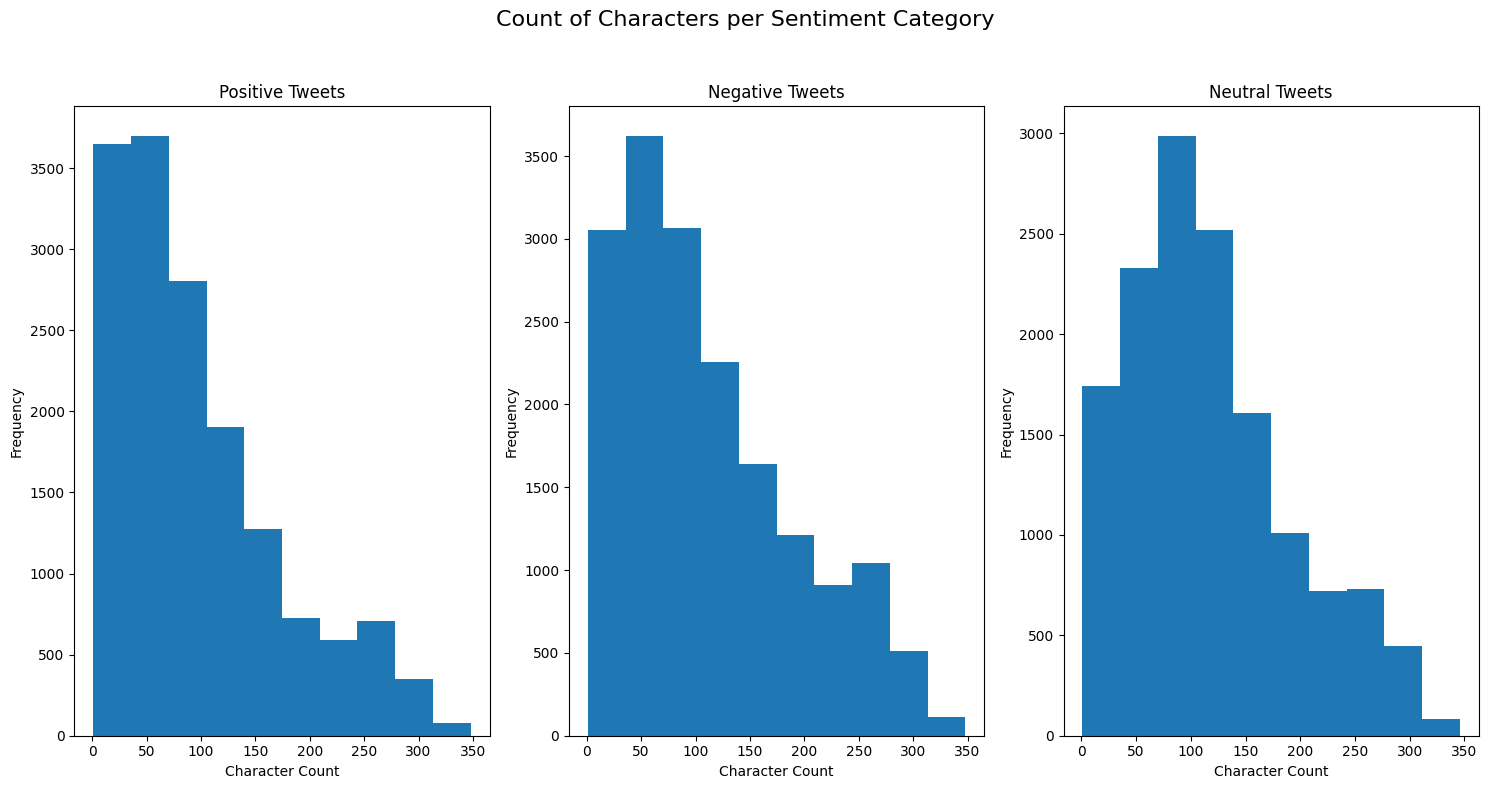

In [105]:
#Character Count

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Positive Tweets
ax1.hist(df[df['sentiment'] == 'Positive']['char_count'])
ax1.set_title('Positive Tweets')
ax1.set_xlabel('Character Count')  
ax1.set_ylabel('Frequency')          

# Negative Tweets
ax2.hist(df[df['sentiment'] == 'Negative']['char_count'])
ax2.set_title('Negative Tweets')
ax2.set_xlabel('Character Count')  
ax2.set_ylabel('Frequency')        

# Neutral Tweets
ax3.hist(df[df['sentiment'] == 'Neutral']['char_count'])
ax3.set_title('Neutral Tweets')
ax3.set_xlabel('Character Count') 
ax3.set_ylabel('Frequency')         

plt.suptitle('Count of Characters per Sentiment Category', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

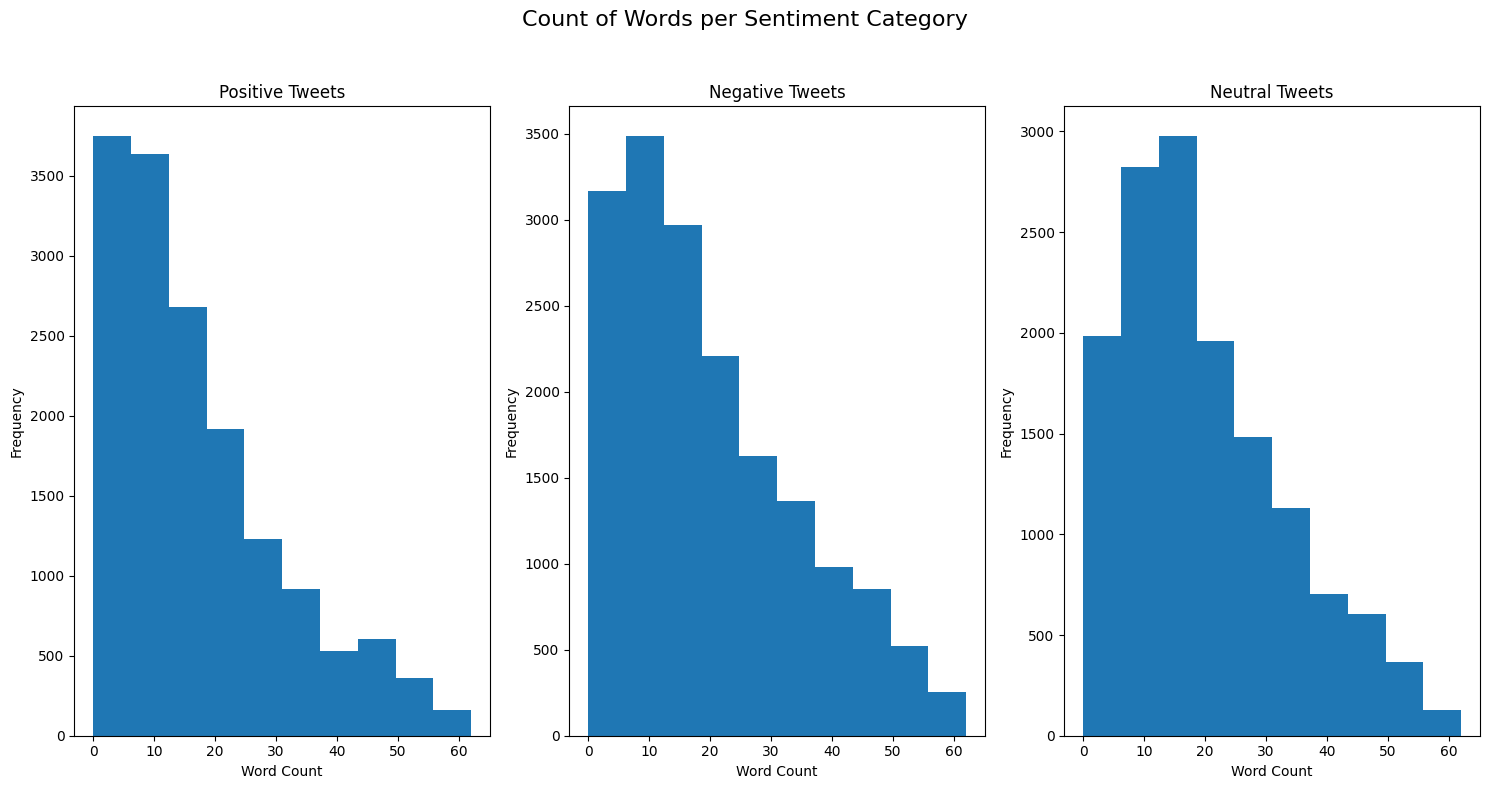

In [106]:
# Word Count

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Positive Tweets
ax1.hist(df[df['sentiment'] == 'Positive']['word_count'])
ax1.set_title('Positive Tweets')
ax1.set_xlabel('Word Count')  
ax1.set_ylabel('Frequency')    

# Negative Tweets
ax2.hist(df[df['sentiment'] == 'Negative']['word_count'])
ax2.set_title('Negative Tweets')
ax2.set_xlabel('Word Count')  
ax2.set_ylabel('Frequency')    

# Neutral Tweets
ax3.hist(df[df['sentiment'] == 'Neutral']['word_count'])
ax3.set_title('Neutral Tweets')
ax3.set_xlabel('Word Count')  
ax3.set_ylabel('Frequency')   

plt.suptitle('Count of Words per Sentiment Category', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

# Data Preprocessing for Naive-Bayes

## Text cleaning: emojis, toLower etc.

In [53]:
def cleaning(text):
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower()  # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text)  # removing URL links
    text = re.sub(r"\b\d+\b", "", text)  # removing number
    text = re.sub('<.*?>+', '', text)  # removing special characters,
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    #removing emoji:
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # removing short form:
    text = re.sub("isn't", 'is not', text)
    text = re.sub("he's", 'he is', text)
    text = re.sub("wasn't", 'was not', text)
    text = re.sub("there's", 'there is', text)
    text = re.sub("couldn't", 'could not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("they're", 'they are', text)
    text = re.sub("she's", 'she is', text)
    text = re.sub("There's", 'there is', text)
    text = re.sub("wouldn't", 'would not', text)
    text = re.sub("haven't", 'have not', text)
    text = re.sub("That's", 'That is', text)
    text = re.sub("you've", 'you have', text)
    text = re.sub("He's", 'He is', text)
    text = re.sub("what's", 'what is', text)
    text = re.sub("weren't", 'were not', text)
    text = re.sub("we're", 'we are', text)
    text = re.sub("hasn't", 'has not', text)
    text = re.sub("you'd", 'you would', text)
    text = re.sub("shouldn't", 'should not', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("they've", 'they have', text)
    text = re.sub("You'll", 'You will', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub("we've", 'we have', text)
    text = re.sub("it's", 'it is', text)
    text = re.sub("don't", 'do not', text)
    text = re.sub("that´s", 'that is', text)
    text = re.sub("I´m", 'I am', text)
    text = re.sub("it’s", 'it is', text)
    text = re.sub("she´s", 'she is', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('I’m', 'I am', text)
    text = re.sub('I’d', 'I did', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('there’s', 'there is', text)

    return text

In [54]:
dt = df['tweet'].apply(cleaning)

In [55]:
dt = pd.DataFrame(dt)
dt['sentiment'] = df['sentiment']

In [56]:
dt.head()

,tweet,sentiment
0,booo,Negative
1,ok hear me out microsoft is going to pull a mi...,Neutral
2,hopping on the uzi is pretty good fortunate...,Positive
3,mr christoph sandrock best pubg teammate rescu...,Positive
4,eamaddennfl what is up with these player ratin...,Negative


## Stopwords

In [57]:
dt['no_sw'] = dt['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [58]:
dt.head(20)

,tweet,sentiment,no_sw
0,booo,Negative,booo
1,ok hear me out microsoft is going to pull a mi...,Neutral,hear microsoft pull mix ass prove choose xbox ...
2,hopping on the uzi is pretty good fortunate...,Positive,hopping uzi pretty fortunate time twitchtvjoke65
3,mr christoph sandrock best pubg teammate rescu...,Positive,mr christoph sandrock pubg teammate rescuer cr...
4,eamaddennfl what is up with these player ratin...,Negative,eamaddennfl player ratings algorithm wrong
5,im very pleased to see everyone playing cyberp...,Positive,pleased playing cyberpunk completely missing o...
6,a ban for battlefield player itzawwzy has occ...,Irrelevant,ban battlefield player itzawwzy occurred detai...
7,be soon into the warcraft official release m ...,Positive,warcraft official release newsblizzardcomenusw...
8,we need about a third for ranked right around now,Neutral,ranked
9,is,Negative,


## Most frequent words

In [59]:
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(20)
temp = pd.DataFrame(cnt.most_common(20))
temp.columns = ['word', 'count']

In [60]:
temp.head(20)

,word,count
0,game,6275
1,play,2649
2,love,2498
3,time,2280
4,johnson,2271
5,shit,2102
6,games,1759
7,great,1738
8,playing,1665
9,xbox,1632


most frequent words erstmal nicht entfernen (love, shit etc. vmtl. ausschlaggebend für Klassifikation)

In [61]:
# FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
# def remove_freqwords(text):
#     return " ".join([word for word in str(text).split() if word not in FREQWORDS])
# dt["no_sw_no_freqwo"] = dt["no_sw"].apply(lambda text: remove_freqwords(text))

In [62]:
# dt.head()

In [63]:
# dt[dt.no_sw != dt.no_sw_no_freqwo].head()

## Lemmatization

In [64]:
wordnet_lem = WordNetLemmatizer()
dt['no_sw_lem'] = dt['no_sw'].apply(wordnet_lem.lemmatize)

In [65]:
dt.head()

,tweet,sentiment,no_sw,no_sw_lem
0,booo,Negative,booo,booo
1,ok hear me out microsoft is going to pull a mi...,Neutral,hear microsoft pull mix ass prove choose xbox ...,hear microsoft pull mix ass prove choose xbox ...
2,hopping on the uzi is pretty good fortunate...,Positive,hopping uzi pretty fortunate time twitchtvjoke65,hopping uzi pretty fortunate time twitchtvjoke65
3,mr christoph sandrock best pubg teammate rescu...,Positive,mr christoph sandrock pubg teammate rescuer cr...,mr christoph sandrock pubg teammate rescuer cr...
4,eamaddennfl what is up with these player ratin...,Negative,eamaddennfl player ratings algorithm wrong,eamaddennfl player ratings algorithm wrong


In [66]:
dt[dt.no_sw != dt.no_sw_lem].head(500)

,tweet,sentiment,no_sw,no_sw_lem
79,the best uniforms,Positive,uniforms,uniform
222,all comments,Irrelevant,comments,comment
276,last one sounds way too good to be said true,Positive,sounds,sound
1521,lies,Negative,lies,lie
3011,mistakes,Irrelevant,mistakes,mistake
...,...,...,...,...
56977,feels the good man,Positive,feels,feel
57446,hotdogs ever,Positive,hotdogs,hotdog
57471,old days,Irrelevant,days,day
57501,the works for me,Positive,works,work


## Check again: Duplicates / NaN

In [67]:
dt.duplicated().sum()

2135

In [68]:
dt.drop_duplicates(inplace=True)
dt.duplicated().sum()

0

In [72]:
dt.isna().sum()

tweet        0
sentiment    0
no_sw        0
no_sw_lem    0
dtype: int64

In [69]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55151 entries, 0 to 57624
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      55151 non-null  object
 1   sentiment  55151 non-null  object
 2   no_sw      55151 non-null  object
 3   no_sw_lem  55151 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


## Save preprocessed data

In [70]:
filepath = Path('data/twitter_training_cleaned_preprocessed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)

In [71]:
dt.to_csv(filepath)